# >>> Hate Speech Classification <<<

[Dataset 1 - Kaggle](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset)

[Dataset 2 - Kaggle](https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset)

ABOUT DATASET: 
* Dataset using Twitter data, is was used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither. Due to the nature of the study, it’s important to note that this dataset contains text that can be considered racist, sexist, homophobic, or generally offensive.

## Import Libraries

In [65]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the data

In [66]:
df1 = pd.read_csv("../data/labeled_data.csv")
df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## Pre EDA

In [68]:
imbalance_data = df1.loc[:,["class","tweet"]]
imbalance_data.rename(columns={"class": "label"}, inplace=True)
imbalance_data.head()

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


# Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

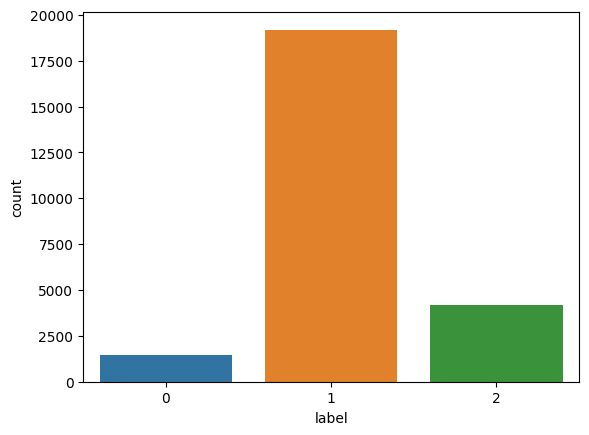

In [69]:
sns.countplot(x='label',data = imbalance_data)

We can see above that the classes are imbalanced

class 0: hate, class 1: abusive, and class 2: no hate.

In [70]:
# Checking the shape of the data
imbalance_data.shape

(24783, 2)

In [71]:
# Cheking if null values are present in the dataset or not.
imbalance_data.isnull().sum()

label    0
tweet    0
dtype: int64

In [72]:
#Let's copy the valus of the class 1 into class 0.
imbalance_data[imbalance_data['label']==0]['target']=1

# Let's check the values in the class 0
imbalance_data[imbalance_data['label']==0]

# replace the value of 0 to 1
imbalance_data["label"].replace({0:1},inplace=True)

imbalance_data["label"].unique()

C:\Users\Alex\AppData\Local\Temp\ipykernel_3312\2476846670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imbalance_data[imbalance_data['label']==0]['target']=1


array([2, 1], dtype=int64)

<Axes: xlabel='label', ylabel='count'>

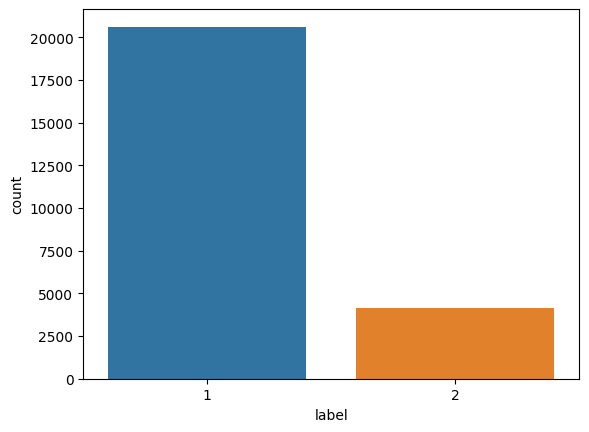

In [74]:
sns.countplot(x='label',data = imbalance_data)

<Axes: xlabel='label', ylabel='count'>

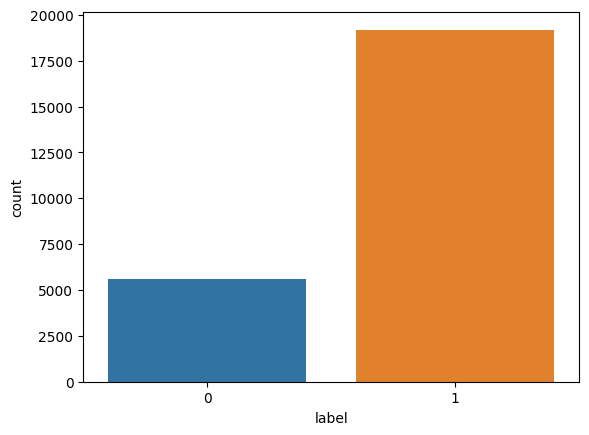

In [ ]:
# Let's replace the value of 2 to 0.
raw_data = imbalance_data.copy(deep=True)
raw_data["label"].replace({2:0}, inplace = True)
# let's visualize
sns.countplot(x='label',data=raw_data)

## Loading the second dataset

In [75]:
df2 = pd.read_csv("../data/toxic_Tweets.csv")
df2.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,4,0,factsguide: society now #motivation


In [76]:
df2 = df2.loc[:,["Toxicity","tweet"]]
# Let's change the name of the 'target' to label
df2.rename(columns={'Toxicity':'label'},inplace =True)

In [78]:
# Let's concatinate both the data into a single data frame.
frame = [raw_data, df2]
df = pd.concat(frame)
df.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [84]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='label', ylabel='count'>

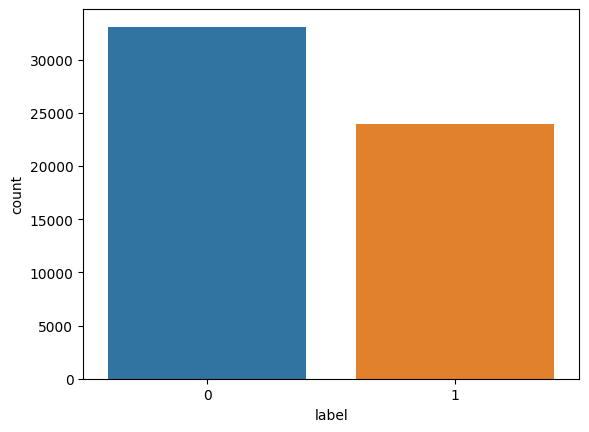

In [85]:
sns.countplot(x='label',data=df)

# Preprocessing

In [86]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [87]:
# Let's apply regex and do cleaning. 

# define a function called data_cleaning that takes a parameter called words
def data_cleaning(words):
    words = str(words).lower() # convert words to a lowercase string
    words = re.sub('\[.*?\]', '', words) # remove any text between square brackets using a regular expression
    words = re.sub('https?://\S+|www\.\S+', '', words) # remove any web link 
    words = re.sub('<.*?>+', '', words) # remove any HTML tag 
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words) # remove any punctuation 
    words = re.sub('\n', '', words) # remove any newlines
    words = re.sub('\w*\d\w*', '', words) # remove any word containing numbers
    words = [word for word in words.split(' ') if words not in stopword] # create a list of words that are not in the stopword list
    words=" ".join(words) # join the list of words into a text string
    words = [stemmer.stem(words) for word in words.split(' ')] # create a list of words by applying the stemming algorithm (stemmer) to each word
    words=" ".join(words) # merge the list of words into a space-separated string

    return words

In [88]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [90]:
df.head()

,label,tweet
0,0,rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...
1,1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...
2,1,rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start ...
3,1,rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cgander...
4,1,rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts th...


In [91]:
# Split data
x = df['tweet']
y = df['label']

In [92]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42775 42775
14259 14259


In [93]:
# Show the type of the data
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [95]:
max_words = 50000 # set the maximum number of words to be used in the tokenizer 
max_len = 300 # set the maximum length of each sequence (text) to be padded 
tokenizer = Tokenizer(num_words=max_words) # create a tokenizer object with the specified number of words 
tokenizer.fit_on_texts(x_train) # fit the tokenizer on the training texts (x_train) 
sequences = tokenizer.texts_to_sequences(x_train) # convert the training texts into sequences of integers 
sequences_matrix = pad_sequences(sequences,maxlen=max_len) # pad or truncate the sequences to have the same length (max_len)

## Modeling

In [144]:
# Creating model architecture.

model = Sequential() # crear un modelo secuencial, que consiste en una pila lineal de capas
model.add(Embedding(max_words,100,input_length=max_len)) # agregar una capa de embedding, que convierte los índices de palabras en vectores densos de tamaño 100
model.add(SpatialDropout1D(0.2)) # agregar una capa de dropout espacial, que aplica una tasa de dropout del 20% a las características de entrada a lo largo de una dimensión
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2)) # agregar una capa de LSTM, que es un tipo de red neuronal recurrente que puede procesar secuencias de datos, con 100 unidades ocultas y una tasa de dropout del 20% tanto para las entradas como para las conexiones recurrentes
model.add(Dense(1,activation='sigmoid')) # agregar una capa densa, que es una capa totalmente conectada con una sola unidad de salida y una función de activación sigmoide, que produce un valor entre 0 y 1
model.summary() # mostrar un resumen del modelo, con el número de parámetros y la forma de cada capa
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy']) # compilar el modelo, especificando la función de pérdida (loss) a optimizar, el algoritmo de optimización a usar (RMSprop) y la métrica a evaluar (accuracy)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 300, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


## FIT

In [145]:
# Crear un callback stop que monitorea la pérdida de validación (val_loss)
# y detiene el entrenamiento si no mejora en 3 épocas consecutivas
stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1
)

# Crear un callback checkpoint que guarda los pesos del modelo en un archivo
# con el número de época y la pérdida de validación en el nombre
# solo guarda el mejor modelo según la pérdida de validación
# checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', save_best_only=True)
checkpoint = ModelCheckpoint(
    filepath='model-{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [146]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 2,
                    validation_split=0.2,callbacks=[stop, checkpoint])

Epoch 1/2
268/268 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8652
Epoch 1: val_loss improved from inf to 0.27811, saving model to model-01-0.28.h5
268/268 [==============================] - 1200s 4s/step - loss: 0.3420 - accuracy: 0.8652 - val_loss: 0.2781 - val_accuracy: 0.8868
Epoch 2/2
268/268 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9055
Epoch 2: val_loss improved from 0.27811 to 0.27385, saving model to model-02-0.27.h5
268/268 [==============================] - 944s 4s/step - loss: 0.2399 - accuracy: 0.9055 - val_loss: 0.2739 - val_accuracy: 0.8933


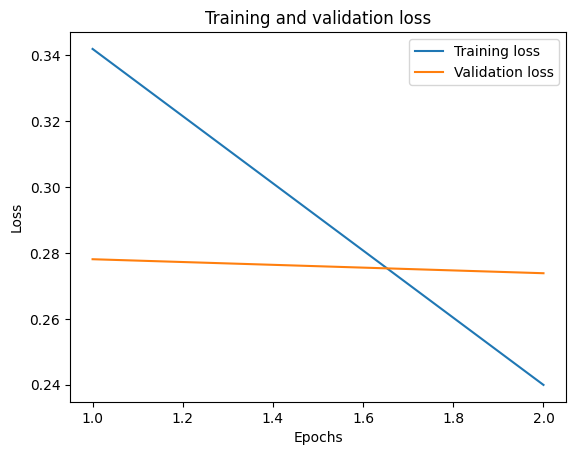

In [147]:
import matplotlib.pyplot as plt # importar la librería matplotlib

# obtener los datos del diccionario history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# crear un gráfico de líneas con los datos
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [148]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [149]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

446/446 [==============================] - 55s 124ms/step - loss: 0.2554 - accuracy: 0.8967


In [150]:
lstm_prediction = model.predict(test_sequences_matrix)

446/446 [==============================] - 57s 126ms/step


In [151]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [152]:
print(confusion_matrix(y_test,res))

[[7669  632]
 [ 841 5117]]


In [153]:
print(confusion_matrix(y_test,res))

[[7669  632]
 [ 841 5117]]


In [154]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Let's save the mdoel.
model.save("model.h5")

In [155]:
import keras

load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [157]:
# Let's test our model on custom data.
test = 't mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred>0.5:
    print(" hate")
else:
    print("no hate")

t mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the
t mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the
['mayasolov woman shouldnt complain clean hous amp man alway take trash rt mayasolov woman shouldnt complain clean hous amp man alway take']
[[378, 1231, 1425, 1001, 3532, 33, 109, 6408, 144, 89, 9, 378, 1231, 1425, 1001, 3532, 33, 109, 6408, 144]]
1/1 [==============================] - 0s 152ms/step
pred [[0.26150602]]
no hate


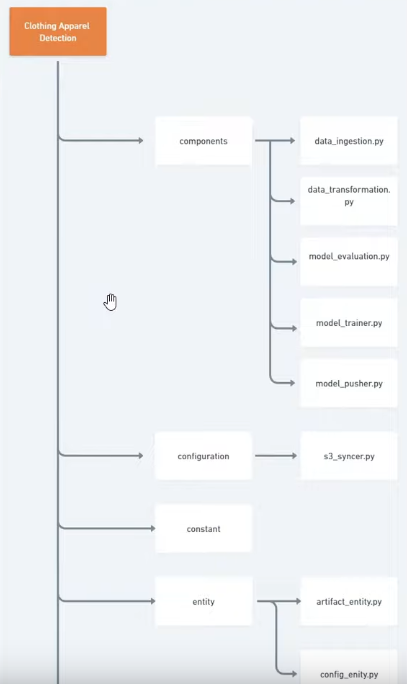

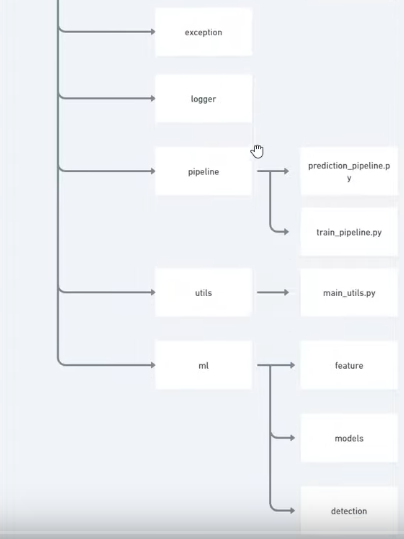